In [ ]:
%pip install fastcore==1.3.19 fastai==2.2.5 rasterio geopandas shapely wandb geojson -Uqq

In [ ]:
#hide
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
#hide
from fastai.vision.models import *
from fastai.vision.all import *

from tqdm import tqdm
from pdb import set_trace
from pprint import pprint
from pathlib import Path
import wandb
from fastai.callback.wandb import * 

warnings.filterwarnings("ignore")

path = Path('/content/drive/My Drive/cv/cv_527/xview_data/train')
type(path)
Path.BASE_PATH = path

In [ ]:
#hide
# Checking what Google Colab is offering today :)
try:
  torch.cuda.get_device_properties(0)
except:
  print("No CUDA device available.")

In [ ]:
import torchvision.models as models
mobilenet = models.mobilenet_v2(pretrained=True)

BATCH_SIZE = 8 # 3 for xresnet50, 12 for xresnet34 with Tesla P100 (16GB)
TILES_PER_SCENE = 16
ARCHITECTURE = mobilenet
EPOCHS = 40
CLASS_WEIGHTS = [0.25,0.75]
LR_MAX = 3e-3
ENCODER_FACTOR = 10
CODES = ['Land','Building']

In [ ]:
#hide
# Weights and Biases config
config_dictionary = dict(
    bs=BATCH_SIZE,
    tiles_per_scene=TILES_PER_SCENE,
    architecture = str(ARCHITECTURE),
    epochs = EPOCHS,
    class_weights = CLASS_WEIGHTS,
    lr_max = LR_MAX,
    encoder_factor = ENCODER_FACTOR
)

## Preprocessing

Exploring dataset structure, display sample scene directories:

In [ ]:
#collapse 
scenes = (path/'images').ls().sorted()
print(f'Numer of scenes: {len(scenes)}')
pprint(list(scenes)[:5])

Numer of scenes: 5598
[Path('images/guatemala-volcano_00000000_post_disaster.png'),
 Path('images/guatemala-volcano_00000000_pre_disaster.png'),
 Path('images/guatemala-volcano_00000001_post_disaster.png'),
 Path('images/guatemala-volcano_00000001_pre_disaster.png'),
 Path('images/guatemala-volcano_00000002_post_disaster.png')]


Which folders are in each scene (the last three have been added later during processing)

In [ ]:
#collapse
images_masked = scenes
labels = (path/'labels').ls().sorted()
print(f'Numer of images in scene: {len(images_masked)}')
pprint(list(images_masked[:5]))

Numer of images in scene: 5598
[Path('images/guatemala-volcano_00000000_post_disaster.png'),
 Path('images/guatemala-volcano_00000000_pre_disaster.png'),
 Path('images/guatemala-volcano_00000001_post_disaster.png'),
 Path('images/guatemala-volcano_00000001_pre_disaster.png'),
 Path('images/guatemala-volcano_00000002_post_disaster.png')]


How many images are in a specific scene:

In [ ]:
index_list = []
index = 0
for ele in labels:
  if 'hurricane-florence_00000015' in ele.name:
    index_list.append(index)
  index += 1
index_list

In [ ]:
image = images_masked[49]

In [ ]:
def get_masked_images(path:Path, n=1)->list:
    "Returns the first `n` pictures from every scene"
    files = []
    for folder in path.ls():
        print("get_image_files(path=folder, folders='images') ", get_image_files(path=folder, folders='images'))
        files.extend(get_image_files(path=folder, folders='images')[:n])

    # print(files)
    return files

def cut_tiles(tile_size:int):
    "Cuts the large images and masks into equal tiles and saves them to disk"
#     masked_images = get_masked_images(path, 5)
#     print( (path/'images').ls())
    masked_images = []
    m_images = (path/'images').ls().sorted()
    all_masks = (path/'masks').ls().sorted()

    for ma in all_masks:
      for mi in m_images:
          if ma.name == mi.name:
              masked_images.append(mi)
    # print(masked_images)
    fast_im = masked_images
    for fn in tqdm(fast_im):
        scene = fn.parent.parent
        # print(scene)

        # Create directories
        if not os.path.exists(path/'img_tiles'):
            os.makedirs(path/'img_tiles')
        if not os.path.exists(path/'mask_tiles'):
            os.makedirs(path/'mask_tiles')

        # Create mask for current image
        img = np.array(PILImage.create(fn))
#         msk_fn = str(fn).replace('images_masked', 'binary_mask')
        msk_fn = str(fn.name).replace('images_masked', 'masks')
        # print("fn, ", fn)
        # print("msk_fn, ", msk_fn)
        msk = np.array(PILMask.create(path/'masks'/msk_fn))
        # print("msk ", path/'masks'/msk_fn)
        x, y, _ = img.shape
        from threading import Thread

        # Cut tiles and save them
        for i in range(x//tile_size):
            Thread(target=(lambda: somethread(i, y, tile_size, fn, scene, img, msk) )).start()
            


def somethread(i, y, tile_size, fn, scene, img, msk):
   for j in range(y//tile_size):
      img_tile = img[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
      msk_tile = msk[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
      Image.fromarray(img_tile).save(f'{scene}/img_tiles/{fn.name[:-4]}_{i}_{j}.png')
      Image.fromarray(msk_tile).save(f'{scene}/mask_tiles/{fn.name[:-4]}_{i}_{j}.png')               


In [ ]:
TILE_SIZE = 255
cut_tiles(TILE_SIZE)

In [ ]:
def get_image_tiles(path:Path, n_tiles=TILES_PER_SCENE) -> L:
  "Returns a list of the first `n` image tile filenames in `path`"
  files = L()
  masked_files = (path/'mask_tiles').ls().sorted()

  for fi in masked_files:
    files.append(Path(str(fi).replace("mask_tiles", "img_tiles3")))

  # for folder in :
  #   files.extend(get_image_files(path=folder, folders='img_tiles')[:n_tiles])
  #   print(files)
  return files

In [ ]:
def get_y_fn(fn:Path) -> str:
  "Returns filename of the associated mask tile for a given image tile"
  return str(fn).replace('img_tiles3', 'mask_tiles')

def get_x_fn(fn:Path) -> str:
  "Returns filename of the associated mask tile for a given image tile"
  return str(fn).replace('mask_tiles3', 'img_tiles')


def get_y(fn:Path) -> PILMask:
  "Returns a PILMask object of 0s and 1s for a given tile"
  fn = get_y_fn(fn)
  msk = np.array(PILMask.create(fn))
  msk[msk==255] = 1
  return PILMask.create(msk)

def get_x(fn:Path) -> PILMask:
  "Returns a PILMask object of 0s and 1s for a given tile"
  fn = get_x_fn(fn)
  # print("fn return ", fn)
  msk = np.array(PILMask.create(fn))
  # msk[msk==255] = 1
  # return PILMask.create(msk)
  # return PILMask.create(fn)
  return (msk)


In [ ]:
#collapse
def show_tiles(n):
  all_tiles = get_image_tiles(path)
  # print(all_tiles)

  mask_files = (path/'mask_tiles').ls().sorted()

  subset = random.sample(mask_files, n)
  fig, ax = plt.subplots(n//2, 4, figsize=(14,14))
  for i in range(n):
    y = i//2
    x = 2*i%4
    new_p = Path(str(subset[i]).replace("mask_tiles", "img_tiles3"))
    PILImage.create(new_p).show(ctx=ax[y, x])

    PILImage.create(subset[i]).show(ctx=ax[y, x+1])

  fig.tight_layout()
  plt.show()

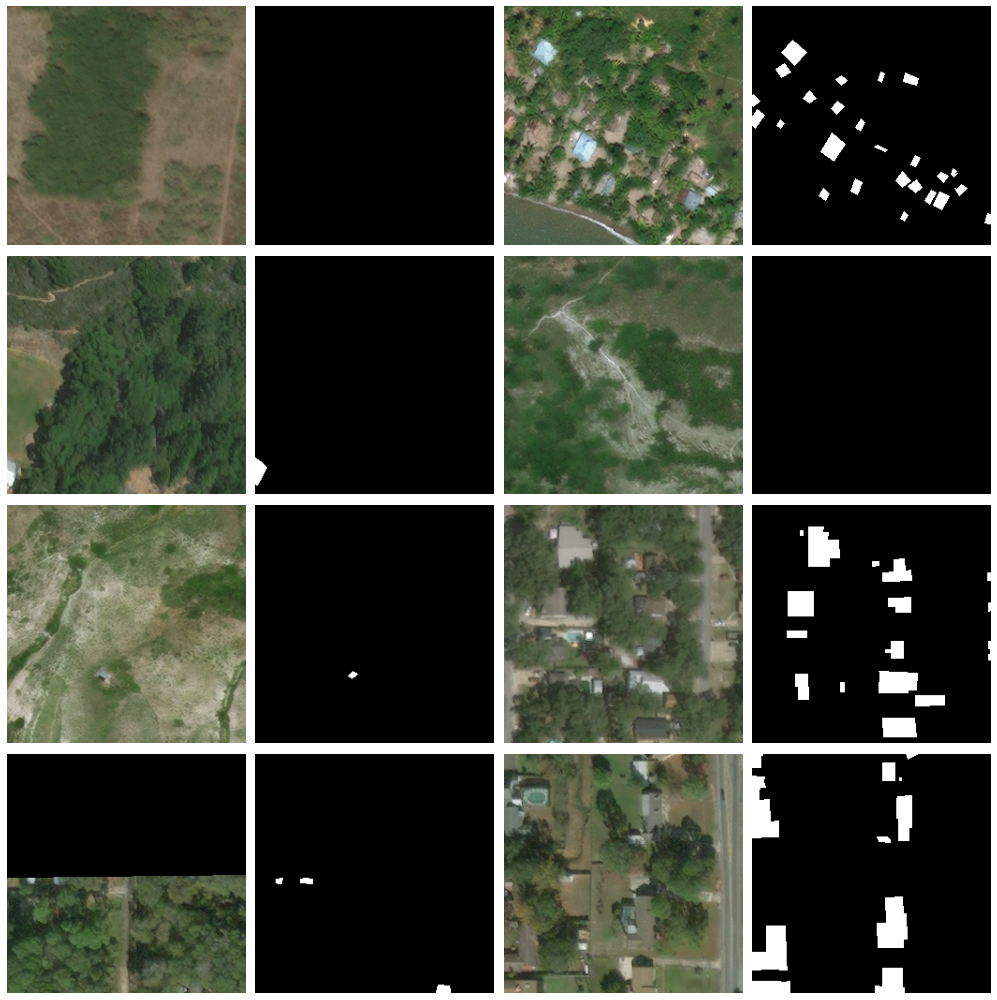

In [ ]:
show_tiles(8)

In [ ]:
def get_input_images(path):
  mask_contained_images = []
  mask_files = (path/'mask_tiles').ls().sorted()
  non_existing_files = ['/content/drive/My Drive/cv/cv_527/xview_data/train/mask_tiles/guatemala-volcano_00000007_pre_disaster_0_2 (1).png', 'uatemala-volcano_00000001_pre_disaster_1_2 (1)']
  for mk_f in mask_files:
    if mk_f not in non_existing_files:
      new_p = Path(str(mk_f).replace("mask_tiles", "img_tiles3"))
      mask_contained_images.append(new_p)
  # print("mask_contained_images ", mask_contained_images)
  return mask_contained_images


In [ ]:
def get_target_mask(path):
  # print("path , ",path) 
  new_p = Path(str(path).replace( "img_tiles3", "mask_tiles"))
  return (new_p)

In [ ]:
ALL_VALID_NAMES = [
'mexico-earthquake_00000015_post_disaster',
'palu-tsunami_00000072_post_disaster',
'socal-fire_00000313_pre_disaster',
'hurricane-florence_00000168_pre_disaster',
'hurricane-florence_00000065_pre_disaster',
'socal-fire_00001331_pre_disaster',
'midwest-flooding_00000018_post_disaster',
'santa-rosa-wildfire_00000065_pre_disaster',
'hurricane-florence_00000359_pre_disaster',
'socal-fire_00000681_pre_disaster',
'hurricane-florence_00000285_post_disaster',
'hurricane-harvey_00000413_post_disaster',
'hurricane-harvey_00000245_pre_disaster',
'socal-fire_00001080_pre_disaster',
'socal-fire_00001307_post_disaster',
'midwest-flooding_00000281_pre_disaster',
'hurricane-michael_00000152_post_disaster',
'socal-fire_00000953_post_disaster',
'hurricane-florence_00000335_post_disaster',
'santa-rosa-wildfire_00000168_post_disaster',
'hurricane-harvey_00000157_pre_disaster',
'santa-rosa-wildfire_00000293_pre_disaster',
'socal-fire_00000926_pre_disaster',
'hurricane-matthew_00000143_post_disaster',
'hurricane-florence_00000260_post_disaster',
'socal-fire_00000084_post_disaster',
'midwest-flooding_00000399_post_disaster',
'hurricane-florence_00000118_post_disaster',
'hurricane-florence_00000242_post_disaster',
'hurricane-florence_00000486_pre_disaster',
'midwest-flooding_00000326_pre_disaster',
'hurricane-matthew_00000256_pre_disaster',
'hurricane-matthew_00000056_pre_disaster',
'socal-fire_00000502_post_disaster',
'socal-fire_00000508_post_disaster',
'santa-rosa-wildfire_00000078_post_disaster',
'mexico-earthquake_00000125_post_disaster',
'socal-fire_00000917_pre_disaster',
'hurricane-michael_00000497_post_disaster',
'guatemala-volcano_00000027_post_disaster',
'hurricane-harvey_00000319_pre_disaster',
'socal-fire_00000471_post_disaster',
'socal-fire_00001355_post_disaster',
'hurricane-harvey_00000029_post_disaster',
'socal-fire_00000102_pre_disaster',
'hurricane-florence_00000274_pre_disaster',
'hurricane-florence_00000490_post_disaster',
'hurricane-florence_00000247_post_disaster',
'socal-fire_00001198_post_disaster',
'socal-fire_00001244_pre_disaster',
'hurricane-florence_00000320_post_disaster',
'hurricane-michael_00000299_pre_disaster',
'hurricane-matthew_00000376_post_disaster',
'hurricane-harvey_00000231_pre_disaster',
'santa-rosa-wildfire_00000223_pre_disaster',
'hurricane-florence_00000023_post_disaster',
'midwest-flooding_00000303_post_disaster',
'socal-fire_00001104_pre_disaster',
'hurricane-harvey_00000446_pre_disaster',
'hurricane-florence_00000222_post_disaster',
'hurricane-harvey_00000502_pre_disaster',
'hurricane-harvey_00000206_post_disaster',
'hurricane-michael_00000008_pre_disaster',
'hurricane-michael_00000243_post_disaster',
'socal-fire_00001152_post_disaster',
'socal-fire_00000888_post_disaster',
'socal-fire_00000334_pre_disaster',
'hurricane-matthew_00000241_pre_disaster',
'midwest-flooding_00000084_pre_disaster',
'hurricane-matthew_00000238_post_disaster',
'mexico-earthquake_00000084_pre_disaster',
'socal-fire_00000994_post_disaster',
'socal-fire_00001351_pre_disaster',
'socal-fire_00001348_post_disaster',
'hurricane-harvey_00000220_post_disaster',
'hurricane-harvey_00000300_post_disaster',
'midwest-flooding_00000407_post_disaster',
'mexico-earthquake_00000132_post_disaster',
'hurricane-michael_00000047_post_disaster',
'socal-fire_00000710_pre_disaster',
'hurricane-harvey_00000132_post_disaster',
'hurricane-harvey_00000302_post_disaster',
'hurricane-michael_00000516_pre_disaster',
'hurricane-matthew_00000207_post_disaster',
'santa-rosa-wildfire_00000151_post_disaster',
'palu-tsunami_00000069_pre_disaster',
'socal-fire_00000662_pre_disaster',
'hurricane-harvey_00000076_pre_disaster',
'hurricane-michael_00000154_post_disaster',
'hurricane-michael_00000303_post_disaster',
'hurricane-florence_00000002_post_disaster',
'socal-fire_00000079_post_disaster',
'santa-rosa-wildfire_00000356_post_disaster',
'socal-fire_00000793_pre_disaster',
'santa-rosa-wildfire_00000129_post_disaster',
'mexico-earthquake_00000160_pre_disaster',
'socal-fire_00001127_pre_disaster',
'hurricane-harvey_00000448_pre_disaster',
'midwest-flooding_00000313_pre_disaster',
'midwest-flooding_00000209_pre_disaster',
'socal-fire_00000070_post_disaster',
'socal-fire_00000566_pre_disaster',
'hurricane-florence_00000075_pre_disaster',
'santa-rosa-wildfire_00000248_post_disaster',
'midwest-flooding_00000351_pre_disaster',
'hurricane-michael_00000308_pre_disaster',
'hurricane-michael_00000038_post_disaster',
'socal-fire_00000926_post_disaster',
'hurricane-michael_00000386_post_disaster',
'socal-fire_00000248_pre_disaster',
'hurricane-florence_00000256_pre_disaster',
'hurricane-florence_00000454_post_disaster',
'hurricane-michael_00000326_post_disaster',
'socal-fire_00000237_post_disaster',
'hurricane-florence_00000336_pre_disaster',
'hurricane-matthew_00000129_pre_disaster',
'socal-fire_00001376_post_disaster',
'santa-rosa-wildfire_00000140_pre_disaster',
'socal-fire_00001257_post_disaster',
'hurricane-florence_00000012_post_disaster',
'hurricane-florence_00000032_pre_disaster',
'socal-fire_00000042_post_disaster',
'hurricane-florence_00000538_post_disaster',
'socal-fire_00000895_post_disaster',
'mexico-earthquake_00000143_pre_disaster',
'palu-tsunami_00000178_pre_disaster',
'hurricane-matthew_00000335_post_disaster',
'hurricane-michael_00000306_post_disaster',
'socal-fire_00001242_pre_disaster',
'hurricane-harvey_00000094_post_disaster',
'socal-fire_00000154_pre_disaster',
'hurricane-michael_00000415_pre_disaster',
'santa-rosa-wildfire_00000151_pre_disaster',
'palu-tsunami_00000177_pre_disaster',
'hurricane-michael_00000118_pre_disaster',
'socal-fire_00000840_pre_disaster',
'hurricane-matthew_00000310_pre_disaster',
'hurricane-matthew_00000062_pre_disaster',
'palu-tsunami_00000134_pre_disaster',
'socal-fire_00000402_pre_disaster',
'mexico-earthquake_00000035_pre_disaster',
'hurricane-matthew_00000013_pre_disaster',
'hurricane-florence_00000450_pre_disaster',
'palu-tsunami_00000058_post_disaster',
'socal-fire_00000704_pre_disaster',
'hurricane-harvey_00000473_pre_disaster',
'hurricane-florence_00000424_pre_disaster',
'socal-fire_00000663_post_disaster',
'hurricane-matthew_00000134_pre_disaster',
'mexico-earthquake_00000043_pre_disaster',
'socal-fire_00000277_pre_disaster',
'midwest-flooding_00000277_post_disaster',
'hurricane-matthew_00000283_post_disaster',
'hurricane-harvey_00000039_post_disaster',
'midwest-flooding_00000203_post_disaster',
'hurricane-harvey_00000177_pre_disaster',
'socal-fire_00000430_post_disaster',
'socal-fire_00001178_pre_disaster',
'socal-fire_00000962_pre_disaster',
'santa-rosa-wildfire_00000357_pre_disaster',
'midwest-flooding_00000356_post_disaster',
'hurricane-matthew_00000045_pre_disaster',
'santa-rosa-wildfire_00000199_post_disaster',
'socal-fire_00001289_post_disaster',
'hurricane-michael_00000228_pre_disaster',
'santa-rosa-wildfire_00000076_post_disaster',
'socal-fire_00000599_pre_disaster',
'socal-fire_00001256_post_disaster',
'socal-fire_00000160_pre_disaster',
'hurricane-matthew_00000265_post_disaster',
'midwest-flooding_00000170_pre_disaster',
'santa-rosa-wildfire_00000170_post_disaster',
'hurricane-michael_00000340_post_disaster',
'socal-fire_00001054_post_disaster',
'hurricane-florence_00000542_pre_disaster',
'midwest-flooding_00000161_post_disaster',
'socal-fire_00001081_pre_disaster',
'palu-tsunami_00000134_post_disaster',
'socal-fire_00000227_post_disaster',
'palu-tsunami_00000121_post_disaster',
'hurricane-matthew_00000328_pre_disaster',
'hurricane-harvey_00000061_post_disaster',
'hurricane-florence_00000418_pre_disaster',
'hurricane-matthew_00000354_pre_disaster',
'hurricane-michael_00000200_pre_disaster',
'palu-tsunami_00000053_pre_disaster',
'hurricane-matthew_00000097_post_disaster',
'hurricane-harvey_00000392_pre_disaster',
'socal-fire_00000589_post_disaster',
'socal-fire_00000556_pre_disaster',
'socal-fire_00001043_post_disaster',
'mexico-earthquake_00000168_pre_disaster',
'socal-fire_00001104_post_disaster',
'socal-fire_00001296_post_disaster',
'midwest-flooding_00000190_post_disaster',
'hurricane-harvey_00000356_pre_disaster',
'hurricane-michael_00000465_pre_disaster',
'hurricane-florence_00000084_post_disaster',
'hurricane-harvey_00000389_post_disaster',
'socal-fire_00000285_pre_disaster',
'socal-fire_00000624_pre_disaster',
'midwest-flooding_00000229_post_disaster',
'socal-fire_00000472_post_disaster',
'socal-fire_00000966_post_disaster',
'socal-fire_00000369_post_disaster',
'socal-fire_00000827_pre_disaster',
'hurricane-harvey_00000233_pre_disaster',
'santa-rosa-wildfire_00000101_pre_disaster',
'hurricane-michael_00000251_pre_disaster',
'midwest-flooding_00000290_pre_disaster',
'hurricane-matthew_00000305_pre_disaster',
'socal-fire_00000791_post_disaster',
'hurricane-florence_00000441_pre_disaster',
'mexico-earthquake_00000082_pre_disaster',
'socal-fire_00000820_pre_disaster',
'socal-fire_00000144_post_disaster',
'hurricane-michael_00000273_pre_disaster',
'midwest-flooding_00000388_post_disaster',
'hurricane-florence_00000437_post_disaster',
'hurricane-matthew_00000373_post_disaster',
'mexico-earthquake_00000008_pre_disaster',
'hurricane-michael_00000392_post_disaster',
'socal-fire_00000465_pre_disaster',
'socal-fire_00000427_post_disaster',
'hurricane-michael_00000233_pre_disaster',
'socal-fire_00000620_pre_disaster',
'socal-fire_00001146_post_disaster',
'hurricane-michael_00000356_pre_disaster',
'midwest-flooding_00000033_post_disaster',
'hurricane-matthew_00000341_post_disaster',
'palu-tsunami_00000183_post_disaster',
'santa-rosa-wildfire_00000084_post_disaster',
'hurricane-matthew_00000233_post_disaster',
'hurricane-florence_00000189_pre_disaster',
'santa-rosa-wildfire_00000324_pre_disaster',
'hurricane-harvey_00000260_pre_disaster',
'santa-rosa-wildfire_00000308_post_disaster',
'hurricane-michael_00000144_pre_disaster',
'midwest-flooding_00000398_post_disaster',
'hurricane-harvey_00000461_post_disaster',
'midwest-flooding_00000255_pre_disaster',
'midwest-flooding_00000316_post_disaster',
'socal-fire_00001203_post_disaster',
'hurricane-florence_00000266_pre_disaster',
'hurricane-harvey_00000347_pre_disaster',
'palu-tsunami_00000065_pre_disaster',
'hurricane-matthew_00000239_post_disaster',
'hurricane-michael_00000535_pre_disaster',
'hurricane-harvey_00000208_pre_disaster',
'socal-fire_00000002_pre_disaster',
'hurricane-harvey_00000174_post_disaster',
'hurricane-michael_00000487_pre_disaster',
'hurricane-matthew_00000062_post_disaster',
'hurricane-florence_00000122_post_disaster',
'hurricane-michael_00000419_pre_disaster',
'socal-fire_00000892_post_disaster',
'hurricane-harvey_00000330_pre_disaster',
'mexico-earthquake_00000019_pre_disaster',
'socal-fire_00001353_post_disaster',
'hurricane-harvey_00000006_post_disaster',
'socal-fire_00000887_post_disaster',
'hurricane-harvey_00000224_post_disaster',
'hurricane-michael_00000087_pre_disaster',
'socal-fire_00000105_post_disaster',
'socal-fire_00000798_pre_disaster',
'palu-tsunami_00000140_pre_disaster',
'mexico-earthquake_00000176_pre_disaster',
'socal-fire_00000578_post_disaster',
'mexico-earthquake_00000030_post_disaster',
'midwest-flooding_00000022_pre_disaster',
'hurricane-florence_00000349_pre_disaster',
'mexico-earthquake_00000021_pre_disaster',
'hurricane-harvey_00000442_pre_disaster',
'hurricane-michael_00000210_post_disaster',
'socal-fire_00000901_post_disaster',
'socal-fire_00001067_post_disaster',
'mexico-earthquake_00000122_post_disaster',
'hurricane-harvey_00000142_post_disaster',
'socal-fire_00000230_post_disaster',
'hurricane-harvey_00000001_post_disaster',
'hurricane-harvey_00000434_pre_disaster',
'hurricane-florence_00000132_pre_disaster',
'hurricane-florence_00000088_post_disaster',
'socal-fire_00000001_pre_disaster',
'socal-fire_00001004_pre_disaster',
'hurricane-florence_00000217_post_disaster',
'hurricane-michael_00000044_pre_disaster',
'palu-tsunami_00000107_post_disaster',
'hurricane-michael_00000442_pre_disaster',
'socal-fire_00000540_post_disaster',
'socal-fire_00000581_post_disaster',
'midwest-flooding_00000030_post_disaster',
'midwest-flooding_00000075_post_disaster',
'hurricane-michael_00000230_pre_disaster',
'mexico-earthquake_00000033_pre_disaster',
'hurricane-florence_00000164_post_disaster',
'socal-fire_00000353_post_disaster',
'hurricane-florence_00000419_post_disaster',
'socal-fire_00001112_post_disaster',
'socal-fire_00000022_pre_disaster',
'socal-fire_00000348_pre_disaster',
'hurricane-michael_00000519_pre_disaster',
'hurricane-florence_00000353_pre_disaster',
'socal-fire_00000534_post_disaster',
'palu-tsunami_00000115_pre_disaster',
'midwest-flooding_00000330_post_disaster',
'hurricane-florence_00000045_post_disaster',
'hurricane-harvey_00000146_pre_disaster',
'palu-tsunami_00000109_post_disaster',
'palu-tsunami_00000015_post_disaster',
'socal-fire_00000563_pre_disaster',
'palu-tsunami_00000076_post_disaster',
'palu-tsunami_00000164_post_disaster',
'hurricane-florence_00000540_post_disaster',
'midwest-flooding_00000202_pre_disaster',
'hurricane-michael_00000099_pre_disaster',
'hurricane-matthew_00000001_pre_disaster',
'socal-fire_00000478_pre_disaster',
'hurricane-florence_00000460_post_disaster',
'hurricane-harvey_00000434_post_disaster',
'mexico-earthquake_00000164_pre_disaster',
'mexico-earthquake_00000001_post_disaster',
'hurricane-michael_00000348_pre_disaster',
'palu-tsunami_00000111_pre_disaster',
'hurricane-matthew_00000275_post_disaster',
'hurricane-florence_00000293_post_disaster',
'socal-fire_00000953_pre_disaster',
'midwest-flooding_00000263_post_disaster',
'hurricane-matthew_00000162_pre_disaster',
'socal-fire_00001067_pre_disaster',
'midwest-flooding_00000095_post_disaster',
'hurricane-michael_00000076_pre_disaster',
'mexico-earthquake_00000017_pre_disaster',
'hurricane-michael_00000475_post_disaster',
'hurricane-florence_00000445_pre_disaster',
'midwest-flooding_00000178_post_disaster',
'socal-fire_00001089_post_disaster',
'hurricane-florence_00000523_post_disaster',
'hurricane-matthew_00000130_post_disaster',
'hurricane-michael_00000200_post_disaster',
'hurricane-harvey_00000356_post_disaster',
'socal-fire_00001318_pre_disaster',
'midwest-flooding_00000036_post_disaster',
'hurricane-harvey_00000335_post_disaster',
'hurricane-matthew_00000060_post_disaster',
'socal-fire_00000927_pre_disaster',
'palu-tsunami_00000175_post_disaster',
'hurricane-harvey_00000251_pre_disaster',
'socal-fire_00000536_pre_disaster',
'santa-rosa-wildfire_00000355_post_disaster',
'hurricane-harvey_00000462_pre_disaster',
'hurricane-harvey_00000367_post_disaster',
'hurricane-matthew_00000293_post_disaster',
'hurricane-florence_00000338_post_disaster',
'hurricane-florence_00000229_pre_disaster',
'socal-fire_00001346_pre_disaster',
'midwest-flooding_00000351_post_disaster',
'hurricane-harvey_00000242_post_disaster',
'socal-fire_00000197_pre_disaster',
'hurricane-harvey_00000197_pre_disaster',
'socal-fire_00000287_post_disaster',
'socal-fire_00000957_pre_disaster',
'santa-rosa-wildfire_00000171_pre_disaster',
'hurricane-michael_00000465_post_disaster',
'hurricane-florence_00000506_post_disaster',
'socal-fire_00000661_pre_disaster',
'socal-fire_00001402_pre_disaster',
'santa-rosa-wildfire_00000138_post_disaster',
'hurricane-michael_00000319_post_disaster',
'hurricane-harvey_00000178_pre_disaster',
'mexico-earthquake_00000067_post_disaster',
'socal-fire_00000336_pre_disaster',
'hurricane-harvey_00000055_pre_disaster',
'hurricane-michael_00000239_post_disaster',
'socal-fire_00000096_post_disaster',
'socal-fire_00000718_pre_disaster',
'hurricane-florence_00000142_post_disaster',
'socal-fire_00000197_post_disaster',
'mexico-earthquake_00000138_pre_disaster',
'hurricane-matthew_00000152_pre_disaster',
'santa-rosa-wildfire_00000340_post_disaster',
'hurricane-matthew_00000016_post_disaster',
'hurricane-michael_00000417_pre_disaster',
'santa-rosa-wildfire_00000356_pre_disaster',
'socal-fire_00001215_post_disaster',
'socal-fire_00001101_post_disaster',
'santa-rosa-wildfire_00000241_pre_disaster',
'socal-fire_00000554_pre_disaster',
'palu-tsunami_00000047_post_disaster',
'hurricane-matthew_00000023_post_disaster',
'palu-tsunami_00000133_pre_disaster',
'palu-tsunami_00000073_pre_disaster',
'hurricane-michael_00000295_pre_disaster',
'socal-fire_00000964_post_disaster',
'santa-rosa-wildfire_00000223_post_disaster',
'socal-fire_00000772_pre_disaster',
'santa-rosa-wildfire_00000042_post_disaster',
'palu-tsunami_00000007_pre_disaster',
'hurricane-matthew_00000178_post_disaster',
'midwest-flooding_00000173_pre_disaster',
'hurricane-michael_00000273_post_disaster',
'santa-rosa-wildfire_00000055_post_disaster',
'hurricane-michael_00000050_post_disaster',
'hurricane-harvey_00000514_post_disaster',
'hurricane-harvey_00000210_post_disaster',
'socal-fire_00001319_pre_disaster',
'socal-fire_00000436_pre_disaster',
'mexico-earthquake_00000066_post_disaster',
'socal-fire_00001207_post_disaster',
'mexico-earthquake_00000047_pre_disaster',
'hurricane-matthew_00000171_post_disaster',
'socal-fire_00000061_post_disaster',
'hurricane-florence_00000371_pre_disaster',
'hurricane-michael_00000333_pre_disaster',
'midwest-flooding_00000319_pre_disaster',
'hurricane-michael_00000511_post_disaster',
'midwest-flooding_00000355_post_disaster',
'santa-rosa-wildfire_00000233_post_disaster',
'hurricane-michael_00000060_pre_disaster',
'hurricane-michael_00000260_pre_disaster',
'midwest-flooding_00000353_pre_disaster',
'socal-fire_00000725_post_disaster',
'guatemala-volcano_00000002_post_disaster',
'hurricane-harvey_00000257_post_disaster',
'hurricane-michael_00000319_pre_disaster',
'hurricane-matthew_00000185_post_disaster',
'socal-fire_00000968_pre_disaster',
'hurricane-michael_00000489_pre_disaster',
'santa-rosa-wildfire_00000281_post_disaster',
'midwest-flooding_00000020_pre_disaster',
'santa-rosa-wildfire_00000373_post_disaster',
'santa-rosa-wildfire_00000225_pre_disaster',
'socal-fire_00000692_post_disaster',
'hurricane-harvey_00000145_pre_disaster',
'mexico-earthquake_00000128_pre_disaster',
'palu-tsunami_00000123_post_disaster',
'hurricane-matthew_00000168_post_disaster',
'socal-fire_00000901_pre_disaster',
'socal-fire_00001283_post_disaster',
'socal-fire_00001340_pre_disaster',
'socal-fire_00000388_pre_disaster',
'socal-fire_00000438_post_disaster',
'socal-fire_00001363_post_disaster',
'socal-fire_00001361_pre_disaster',
'hurricane-harvey_00000024_pre_disaster',
'hurricane-michael_00000341_pre_disaster',
'hurricane-harvey_00000438_pre_disaster',
'hurricane-florence_00000190_post_disaster',
'santa-rosa-wildfire_00000158_post_disaster',
'socal-fire_00000785_pre_disaster',
'socal-fire_00000515_pre_disaster',
'socal-fire_00000252_pre_disaster',
'hurricane-michael_00000272_pre_disaster',
'midwest-flooding_00000093_post_disaster',
'hurricane-matthew_00000066_post_disaster',
'hurricane-harvey_00000427_post_disaster',
'socal-fire_00000915_post_disaster',
'socal-fire_00000215_pre_disaster',
'hurricane-florence_00000163_post_disaster',
'santa-rosa-wildfire_00000182_pre_disaster',
'midwest-flooding_00000411_pre_disaster',
'hurricane-harvey_00000060_pre_disaster',
'socal-fire_00001129_post_disaster',
'socal-fire_00000917_post_disaster',
'santa-rosa-wildfire_00000135_pre_disaster',
'santa-rosa-wildfire_00000106_pre_disaster',
'hurricane-harvey_00000167_post_disaster',
'socal-fire_00000601_post_disaster',
'hurricane-michael_00000188_pre_disaster',
'hurricane-matthew_00000188_pre_disaster',
'hurricane-matthew_00000350_post_disaster',
'socal-fire_00001102_pre_disaster',
'midwest-flooding_00000110_post_disaster',
'socal-fire_00000514_post_disaster',
'socal-fire_00001333_pre_disaster',
'hurricane-michael_00000476_pre_disaster',
'hurricane-harvey_00000519_post_disaster',
'santa-rosa-wildfire_00000067_pre_disaster',
'socal-fire_00000980_pre_disaster',
'socal-fire_00000740_pre_disaster',
'hurricane-harvey_00000049_post_disaster',
'hurricane-harvey_00000226_post_disaster',
'hurricane-matthew_00000281_pre_disaster',
'hurricane-matthew_00000126_pre_disaster',
'santa-rosa-wildfire_00000268_pre_disaster',
'hurricane-harvey_00000443_post_disaster',
'socal-fire_00000671_pre_disaster',
'hurricane-harvey_00000043_pre_disaster',
'socal-fire_00000624_post_disaster',
'santa-rosa-wildfire_00000040_pre_disaster',
'hurricane-florence_00000126_pre_disaster',
'socal-fire_00000822_post_disaster',
'santa-rosa-wildfire_00000179_pre_disaster',
'hurricane-michael_00000177_pre_disaster',
'hurricane-florence_00000533_post_disaster',
'santa-rosa-wildfire_00000340_pre_disaster',
'hurricane-florence_00000203_post_disaster',
'palu-tsunami_00000108_post_disaster',
'mexico-earthquake_00000153_pre_disaster',
'socal-fire_00001047_post_disaster',
'santa-rosa-wildfire_00000177_pre_disaster',
'hurricane-matthew_00000301_pre_disaster',
'midwest-flooding_00000407_pre_disaster',
'socal-fire_00000387_post_disaster',
'socal-fire_00000851_pre_disaster',
'santa-rosa-wildfire_00000370_post_disaster',
'hurricane-florence_00000344_pre_disaster',
'socal-fire_00000947_pre_disaster',
'socal-fire_00000835_post_disaster',
'hurricane-michael_00000416_pre_disaster',
'hurricane-florence_00000498_post_disaster',
'socal-fire_00000644_post_disaster',
'hurricane-florence_00000523_pre_disaster',
'midwest-flooding_00000357_pre_disaster',
'socal-fire_00000643_pre_disaster',
'hurricane-michael_00000345_pre_disaster',
'santa-rosa-wildfire_00000306_post_disaster',
'hurricane-michael_00000172_post_disaster',
'socal-fire_00001302_pre_disaster',
'hurricane-michael_00000104_post_disaster',
'hurricane-harvey_00000126_pre_disaster',
'midwest-flooding_00000073_pre_disaster',
'midwest-flooding_00000214_pre_disaster',
'santa-rosa-wildfire_00000138_pre_disaster',
'mexico-earthquake_00000101_pre_disaster',
'midwest-flooding_00000156_pre_disaster',
'socal-fire_00001197_pre_disaster',
'palu-tsunami_00000061_pre_disaster',
'socal-fire_00001377_pre_disaster',
'socal-fire_00000884_pre_disaster',
'socal-fire_00001079_post_disaster',
'hurricane-matthew_00000099_pre_disaster',
'socal-fire_00000795_post_disaster',
'socal-fire_00000560_post_disaster',
'socal-fire_00001156_pre_disaster',
'santa-rosa-wildfire_00000162_pre_disaster',
'socal-fire_00000985_post_disaster',
'hurricane-florence_00000185_pre_disaster',
'mexico-earthquake_00000030_pre_disaster',
'hurricane-harvey_00000123_pre_disaster',
'mexico-earthquake_00000184_pre_disaster',
'midwest-flooding_00000148_pre_disaster',
'hurricane-harvey_00000218_pre_disaster',
'socal-fire_00000253_pre_disaster',
'socal-fire_00000469_post_disaster',
'hurricane-michael_00000514_post_disaster',
'hurricane-michael_00000530_pre_disaster',
'socal-fire_00000541_post_disaster',
'hurricane-florence_00000397_post_disaster',
'hurricane-florence_00000381_pre_disaster',
'socal-fire_00000969_pre_disaster',
'palu-tsunami_00000020_post_disaster',
'santa-rosa-wildfire_00000241_post_disaster',
'hurricane-florence_00000057_pre_disaster',
'hurricane-michael_00000059_post_disaster',
'hurricane-harvey_00000116_post_disaster',
'hurricane-harvey_00000203_pre_disaster',
'midwest-flooding_00000075_pre_disaster',
'socal-fire_00000219_pre_disaster'
]
print(ALL_VALID_NAMES)

['mexico-earthquake_00000015_post_disaster', 'palu-tsunami_00000072_post_disaster', 'socal-fire_00000313_pre_disaster', 'hurricane-florence_00000168_pre_disaster', 'hurricane-florence_00000065_pre_disaster', 'socal-fire_00001331_pre_disaster', 'midwest-flooding_00000018_post_disaster', 'santa-rosa-wildfire_00000065_pre_disaster', 'hurricane-florence_00000359_pre_disaster', 'socal-fire_00000681_pre_disaster', 'hurricane-florence_00000285_post_disaster', 'hurricane-harvey_00000413_post_disaster', 'hurricane-harvey_00000245_pre_disaster', 'socal-fire_00001080_pre_disaster', 'socal-fire_00001307_post_disaster', 'midwest-flooding_00000281_pre_disaster', 'hurricane-michael_00000152_post_disaster', 'socal-fire_00000953_post_disaster', 'hurricane-florence_00000335_post_disaster', 'santa-rosa-wildfire_00000168_post_disaster', 'hurricane-harvey_00000157_pre_disaster', 'santa-rosa-wildfire_00000293_pre_disaster', 'socal-fire_00000926_pre_disaster', 'hurricane-matthew_00000143_post_disaster', 'hur

In [ ]:
import pdb
def valid_split(item):
  # pdb.set_trace()
  scene = item.parent.parent.name
  short_name = item.name[:-8]
  
  return short_name in ALL_VALID_NAMES

#collapse
def has_buildings(fn:Path) -> bool:
  """Returns whether the mask of a given image tile
  contains at least one pixel of a building"""
  fn = get_y_fn(fn)
  msk = tensor(PILMask.create(fn))
  count = torch.count_nonzero(msk)
  return count>0.


import os.path


#collapse
def get_undersampled_tiles(path:Path) -> L:
  """Returns a list of image tile filenames in `path`.
  For tiles in the training set, empty tiles are ignored.
  All tiles in the validation set are included."""

  files = get_image_tiles(path)
  print(files[0])
  train_idxs, valid_idxs = FuncSplitter(valid_split)(files)
  # print("train_idxs, valid_idxs ", train_idxs, valid_idxs )
  print("train_idxs, valid_idxs ", len(train_idxs), len(valid_idxs) )


  tot_len =  len(train_idxs)
  tot_len = tot_len - (tot_len % BATCH_SIZE)
  print("train_files pre ", len(train_idxs) )
  # block_len = int(tot_len * 0.4)
  train_files = L(filter(has_buildings, files[train_idxs]))[:tot_len]
  print("train_files ", len(train_files) )
  print("train_files tot_len ", (tot_len) )

  # train_files = L(filter(has_buildings, files[exist_file_indexes]))


  tot_len =  len(valid_idxs)
  tot_len = tot_len - (tot_len % BATCH_SIZE)

  valid_files = files[valid_idxs][:tot_len]
  print("valid_files ", valid_files)

  return train_files + valid_files

In [ ]:
tfms = [Dihedral(0.5),              # Horizontal and vertical flip
        Rotate(max_deg=180, p=0.9), # Rotation in any direction possible
        Brightness(0.2, p=0.75),
        Contrast(0.2),
        Saturation(0.2),
        Resize(255, method=ResizeMethod.Squish),
        Normalize.from_stats(*imagenet_stats)]

To create the datasets, we use the convenient DataBlock API of fastai. We only load 16 tiles per scene, so only 1 image per region.

In [ ]:
tiles = DataBlock(
      blocks = (ImageBlock(),MaskBlock(codes=CODES)), # Independent variable is Image, dependent variable is Mask
      get_items = get_undersampled_tiles,             # Collect undersampled tiles
      get_y = get_y,                                  # Get dependent variable: mask
      splitter = FuncSplitter(valid_split),           # Split into training and validation set
      # splitter = RandomSplitter(valid_pct=0.2, seed=42),
      batch_tfms = tfms                               # Transforms on GPU: augmentation, normalization
    )                              

In [ ]:
# tiles.summary(path)


In [ ]:
dls = tiles.dataloaders(path, bs=30)

dls = tiles.dataloaders(path, bs=BATCH_SIZE)
dls.vocab = CODES

/content/drive/My Drive/cv/cv_527/xview_data/train/img_tiles3/guatemala-volcano_00000000_pre_disaster_0_0.png
train_idxs, valid_idxs  28476 3200
train_files pre  28476
train_files  16310
train_files tot_len  28472
valid_files  [Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_0.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_1.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_2.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_3.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_0.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_1.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_2.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_3.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_2_0.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_2_1.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_2_2.png'), Path('img_til

In [ ]:
#  torch.save(dls, '/content/drive/My Drive/projects/cv_527/short_dataloader.pth')
# torch.load(dls, '/content/drive/My Drive/projects/cv_527/short_dataloader.pth')


In [ ]:
len(dls.train_ds), len(dls.valid_ds)

(16310, 3192)

In [ ]:
class CustomUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder, n_classes, img_size, blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = model_sizes(encoder, size=imsize)
        sz_chg_idxs = list(reversed(_get_sz_change_idxs(sizes)))
        self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-2:]: layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
        #layers += [ConvLayer(ni, n_classes, ks=1, act_cls=None, norm_type=norm_type, **kwargs)] # HERE
        nf = num_features_model(nn.Sequential(layers[-1])) * (2)
        layers += create_head(nf, n_classes)
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

# @delegates(models.unet.DynamicUnet.__init__)
# def unet_config(**kwargs):
#     "Convenience function to easily create a config for `DynamicUnet`"
#     return kwargs

def custom_unet(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None, config=None, n_in=3, n_out=None,
                 normalize=True, **kwargs):
    "Build a unet learner from `dls` and `arch`"
    if config is None: config = unet_config()
    meta = model_meta.get(arch, _default_meta)
    body = create_body(arch, n_in, pretrained, ifnone(cut, meta['cut']))
    size = dls.one_batch()[0].shape[-2:]
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be infered from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    model = CustomUnet(body, n_out, size, **config) # HERE
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn


#learn = custom_unet(dls, models.mobilenet_v2, loss_func=MSELossFlat(), metrics = [Dice(), foreground_acc])

In [ ]:
weights

tensor([0.2500, 0.7500], device='cuda:0')

In [ ]:

from fastai.vision.models import squeezenet1_0
mobilenet = squeezenet1_0
ARCHITECTURE = mobilenet #(pretrained=True)

weights = Tensor(CLASS_WEIGHTS).cuda()
loss_func = CrossEntropyLossFlat(axis=1, weight=weights)
# print( (Path.cwd()/f'tmp/models/model_.pth').exists() )
pa = '/content/drive/My Drive/cv/cv_527/xview_data/train/squeeze_net_models/'
# for i in range(4): print((Path.cwd()/f'tmp/models/model_{i}.pth').exists())

import os

# arr = os.listdir('/tmp/models/')
# print(arr)


learn = unet_learner(dls,                                 # DataLoaders
                     ARCHITECTURE,                        # xResNet34
                     loss_func = loss_func,               # Weighted cross entropy loss
                     opt_func = Adam,                     # Adam optimizer
                     metrics = [Dice(), foreground_acc],  # Custom metrics
                     self_attention = False,
                     cbs = [SaveModelCallback(
                              monitor='dice',
                              comp=np.greater,
                              fname='best-model'
                            )],
                     path=pa
                     )

# pa = '/content/drive/My Drive/cv/cv_527/xview_data/train/squeeze_net_models/models/best-model.pth'
# learn = load_learner(pa, cpu=False)


This is the full UNet model:

In [ ]:
#collapse_output
learn.model

## Training

We can use fastai's learning rate finder to pick a reasonable learning rate:

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=7.585775847473997e-07)

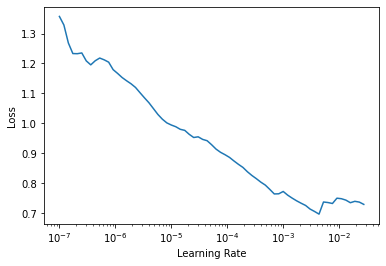

In [ ]:
learn.lr_find(suggestions=True)

Somewhere around 1e-4 seems reasonable, where the loss decreases steadily.

In [ ]:
# lr_max = LR_MAX # 3e-4
lr_max = 0.00043
#collapse-output
# learn.freeze()

start = 0

for i in range(start, start+20):
  print("current cycle saving , ", i)
  learn.load(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_{i}')
  learn.fit_one_cycle(
      # EPOCHS,
      1,
      lr_max=slice(lr_max/ENCODER_FACTOR, lr_max),
      # cbs=[WandbCallback()]
      cbs = [SaveModelCallback(
                                monitor='dice',
                                comp=np.greater,
                                fname='best-model'
                              )]
  )

  learn.save(f'xview2_mobile_unet_learner_{i+1}',  with_opt=True)
  learn.save(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_{i+1}',  with_opt=True)
  learn.export(fname=f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_export_{i+1}.pkl', pickle_module=pickle, pickle_protocol=2)

current cycle saving ,  0


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.230176,0.148436,0.701295,nan,1:01:42


Better model found at epoch 0 with dice value: 0.7012948110439643.
Better model found at epoch 0 with dice value: 0.7012948110439643.
current cycle saving ,  1


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.222965,0.144470,0.705819,nan,1:01:40


Better model found at epoch 0 with dice value: 0.7058185109792796.
Better model found at epoch 0 with dice value: 0.7058185109792796.
current cycle saving ,  2


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.225912,0.143166,0.712197,nan,1:01:43


Better model found at epoch 0 with dice value: 0.7121970626973763.
Better model found at epoch 0 with dice value: 0.7121970626973763.
current cycle saving ,  3


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.208036,0.141479,0.713305,nan,1:01:42


Better model found at epoch 0 with dice value: 0.7133049002740194.
Better model found at epoch 0 with dice value: 0.7133049002740194.
current cycle saving ,  4


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.218320,0.139987,0.715365,nan,1:01:43


Better model found at epoch 0 with dice value: 0.7153646491164428.
Better model found at epoch 0 with dice value: 0.7153646491164428.
current cycle saving ,  5


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.205235,0.139459,0.717960,nan,1:01:42


Better model found at epoch 0 with dice value: 0.7179603893933597.
Better model found at epoch 0 with dice value: 0.7179603893933597.
current cycle saving ,  6


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.212801,0.138598,0.720533,nan,1:01:43


Better model found at epoch 0 with dice value: 0.7205332938805142.
Better model found at epoch 0 with dice value: 0.7205332938805142.
current cycle saving ,  7


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.209194,0.137546,0.720836,nan,1:01:41


Better model found at epoch 0 with dice value: 0.7208359433668136.
Better model found at epoch 0 with dice value: 0.7208359433668136.
current cycle saving ,  8


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.198777,0.137266,0.724677,nan,1:01:43


Better model found at epoch 0 with dice value: 0.7246769916524124.
Better model found at epoch 0 with dice value: 0.7246769916524124.
current cycle saving ,  9


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.219867,0.136110,0.724816,nan,1:01:41


Better model found at epoch 0 with dice value: 0.7248155781106518.
Better model found at epoch 0 with dice value: 0.7248155781106518.
current cycle saving ,  10


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.202641,0.136383,0.728751,nan,1:01:43


Better model found at epoch 0 with dice value: 0.7287512461136724.
Better model found at epoch 0 with dice value: 0.7287512461136724.
current cycle saving ,  11


epoch,train_loss,valid_loss,dice,foreground_acc,time


In [ ]:
# lr_max = LR_MAX # 3e-4
lr_max = 0.00043
#collapse-output
# learn.freeze()

start = 11

for i in range(start, start+10):
  print("current cycle saving , ", i)
  learn.load(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_{i}')
  learn.fit_one_cycle(
      # EPOCHS,
      1,
      lr_max=slice(lr_max/ENCODER_FACTOR, lr_max),
      # cbs=[WandbCallback()]
      cbs = [SaveModelCallback(
                                monitor='dice',
                                comp=np.greater,
                                fname='best-model'
                              )]
  )

  learn.save(f'xview2_mobile_unet_learner_{i+1}',  with_opt=True)
  learn.save(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_{i+1}',  with_opt=True)
  learn.export(fname=f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_export_{i+1}.pkl', pickle_module=pickle, pickle_protocol=2)

current cycle saving ,  11


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.205966,0.135632,0.729221,nan,45:12


Better model found at epoch 0 with dice value: 0.7292211223413793.
Better model found at epoch 0 with dice value: 0.7292211223413793.
current cycle saving ,  12


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.202391,0.136317,0.729964,nan,44:00


Better model found at epoch 0 with dice value: 0.7299643539549922.
Better model found at epoch 0 with dice value: 0.7299643539549922.
current cycle saving ,  13


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.209651,0.133297,0.734130,nan,44:00


Better model found at epoch 0 with dice value: 0.7341301906863393.
Better model found at epoch 0 with dice value: 0.7341301906863393.
current cycle saving ,  14


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.200496,0.133559,0.730575,nan,44:01


Better model found at epoch 0 with dice value: 0.730574511324994.
Better model found at epoch 0 with dice value: 0.730574511324994.
current cycle saving ,  15


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.187163,0.132569,0.731390,nan,44:01


Better model found at epoch 0 with dice value: 0.731390481268604.
Better model found at epoch 0 with dice value: 0.731390481268604.
current cycle saving ,  16


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.205655,0.133273,0.731705,nan,44:01


Better model found at epoch 0 with dice value: 0.7317050469744251.
Better model found at epoch 0 with dice value: 0.7317050469744251.
current cycle saving ,  17


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.198291,0.132827,0.732977,nan,44:02


Better model found at epoch 0 with dice value: 0.7329768254217127.
Better model found at epoch 0 with dice value: 0.7329768254217127.
current cycle saving ,  18


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.198423,0.133287,0.732479,nan,44:02


Better model found at epoch 0 with dice value: 0.732479352885248.
Better model found at epoch 0 with dice value: 0.732479352885248.
current cycle saving ,  19


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.201444,0.132514,0.735371,nan,44:01


Better model found at epoch 0 with dice value: 0.7353707707874549.
Better model found at epoch 0 with dice value: 0.7353707707874549.
current cycle saving ,  20


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.194128,0.131564,0.734498,nan,44:01


Better model found at epoch 0 with dice value: 0.7344981670471198.
Better model found at epoch 0 with dice value: 0.7344981670471198.


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.277874,0.178941,0.653167,nan,43:51
1,0.236715,0.157166,0.688651,nan,43:44
2,0.237912,0.147177,0.699147,nan,43:44
3,0.221033,0.142868,0.713321,nan,43:45
4,0.203955,0.139804,0.716421,nan,43:45


Better model found at epoch 0 with dice value: 0.6531673004467705.
Better model found at epoch 0 with dice value: 0.6531673004467705.


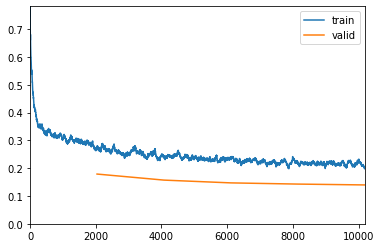

Better model found at epoch 1 with dice value: 0.6886508186109804.
Better model found at epoch 1 with dice value: 0.6886508186109804.
Better model found at epoch 2 with dice value: 0.6991466385361731.
Better model found at epoch 2 with dice value: 0.6991466385361731.
Better model found at epoch 3 with dice value: 0.7133206292699527.
Better model found at epoch 3 with dice value: 0.7133206292699527.
Better model found at epoch 4 with dice value: 0.716421297549229.
Better model found at epoch 4 with dice value: 0.716421297549229.


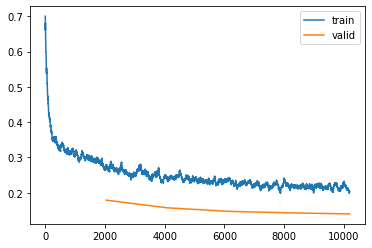

In [ ]:
# lr_max = LR_MAX # 3e-4
lr_max = 0.00043
#collapse-output
# learn.freeze()

start = 21

# for i in range(start, start+10):
# print("current cycle saving , ", i)
# learn.load(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_{i}')
learn.fit_one_cycle(
    # EPOCHS,
    5,
    lr_max=slice(lr_max/ENCODER_FACTOR, lr_max),
    # cbs=[WandbCallback()]
    cbs = [SaveModelCallback(
                              monitor='dice',
                              comp=np.greater,
                              fname='best-model'
                            ),
           ShowGraphCallback()
           ]
)

learn.recorder.plot_loss()

# learn.save(f'xview2_mobile_unet_learner_{i+1}',  with_opt=True)
# learn.save(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_{i+1}',  with_opt=True)
# learn.export(fname=f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_export_{i+1}.pkl', pickle_module=pickle, pickle_protocol=2)

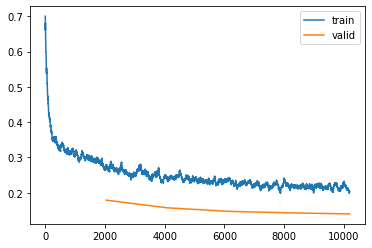

In [ ]:

learn.recorder.plot_loss()

learn.save(f'xview2_mobile_unet_learner_fi',  with_opt=True)
learn.save(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_fi',  with_opt=True)
learn.export(fname=f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_export_f1.pkl', pickle_module=pickle, pickle_protocol=2)

In [ ]:
learn['opt']['state'][1]

{'do_wd': False}

In [ ]:
# learn = 
learn.load(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_{0}')
# print(learn)

In [ ]:

learn.save(f'xview2_mobile_unet_learner_{i}',  with_opt=True)
learn.save(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_{i}',  with_opt=True)
learn.export(fname=f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_export_{i}.pkl', pickle_module=pickle, pickle_protocol=2)

In [ ]:
learn.save('xview2_mobile_unet_learner',  with_opt=True)


In [ ]:
learn.save('/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner',  with_opt=True)

In [ ]:
learn.export(fname='/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_export.pkl', pickle_module=pickle, pickle_protocol=2)

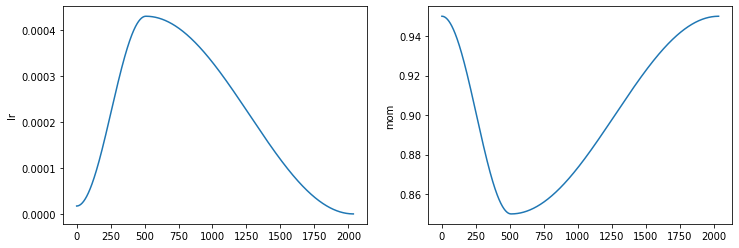

In [ ]:
learn.recorder.plot_sched()

In [ ]:
 learn.recorder.plot_metrics() 

ModuleAttributeError: ignored

In [ ]:
learn.load('best-model');

In [ ]:
#hide
#learn.save(path/'xresnet34-dice-575')

In [ ]:
#hide
#learn.load(path/'xresnet34-dice-575');

In [ ]:
probs,targets,preds,losses = learn.get_preds(dl=dls.valid,
                                             with_loss=True,
                                             with_decoded=True,
                                             act=None)

Sort descending by loss:

In [ ]:
loss_sorted = torch.argsort(losses, descending=True)
n = len(loss_sorted)

Helper function to show predictions:

In [ ]:
#collapse
def show_single_pred(index:int):
  fig, ax = plt.subplots(1, 4, figsize=(20,5))
  dls.valid_ds[index][0].show(ctx=ax[0]);
  ax[0].set_title("Input")
  show_at(dls.valid_ds, index, cmap='Blues', ctx=ax[1]);
  ax[1].set_title("Target")
  preds[index].show(cmap='Blues', ctx=ax[2]);
  ax[2].set_title("Prediction Mask")
  probs[index][1].show(cmap='viridis', ctx=ax[3]);
  ax[3].set_title("Building class probability")

### Plot the samples with the highest losses

In [ ]:
#collapse
for idx in loss_sorted[:10]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

Tile #3001, loss: 0.014605631120502949
Tile #1422, loss: 0.014577806927263737
Tile #108, loss: 0.014511320739984512


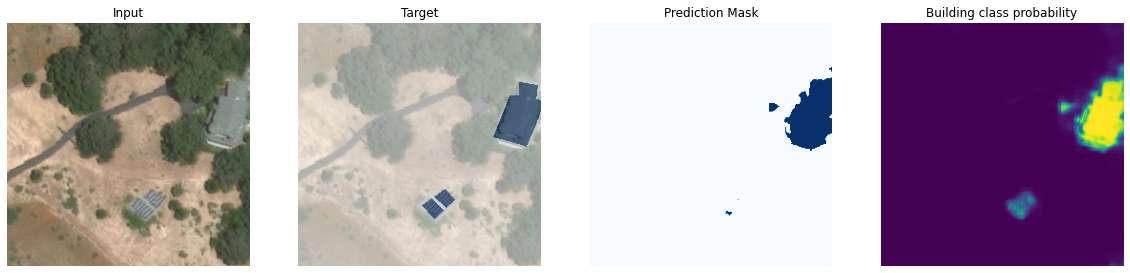

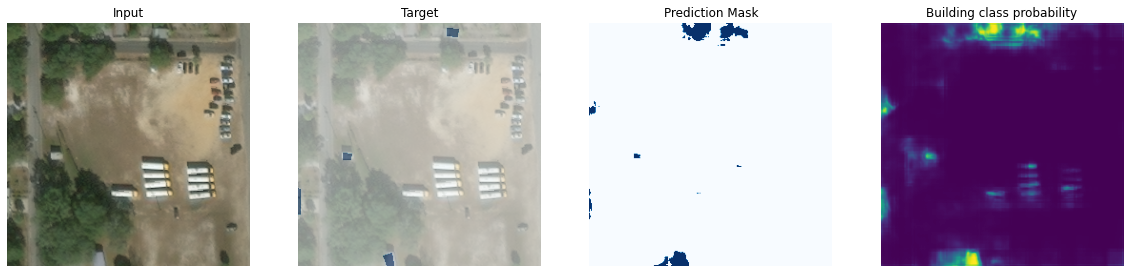

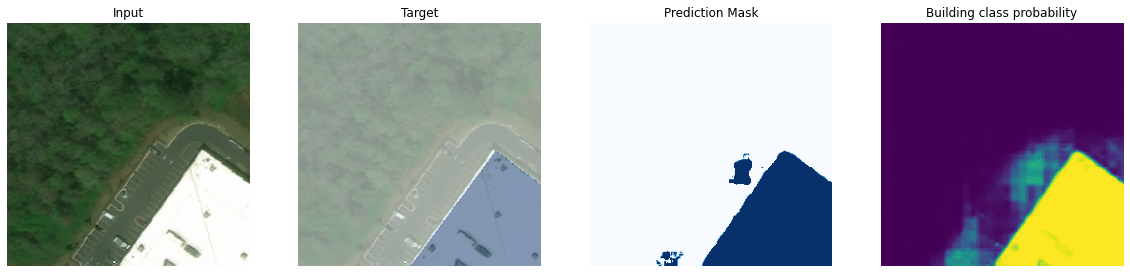

In [ ]:
#collapse
for idx in loss_sorted[n//2-1:n//2+2]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

Tile #461, loss: 1.1038006419994417e-07
Tile #459, loss: 1.1038006419994417e-07
Tile #457, loss: 1.1038006419994417e-07


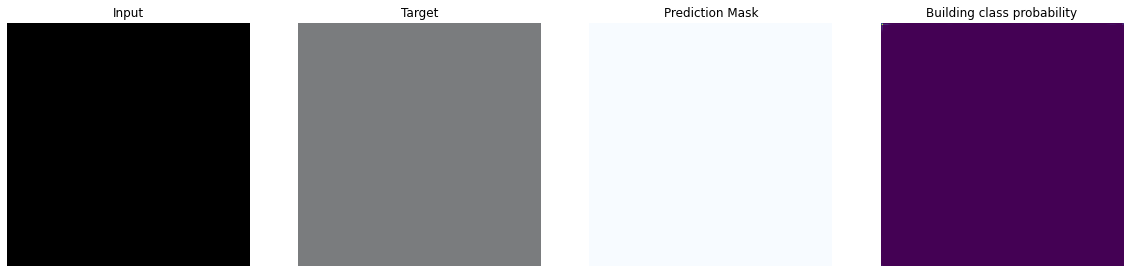

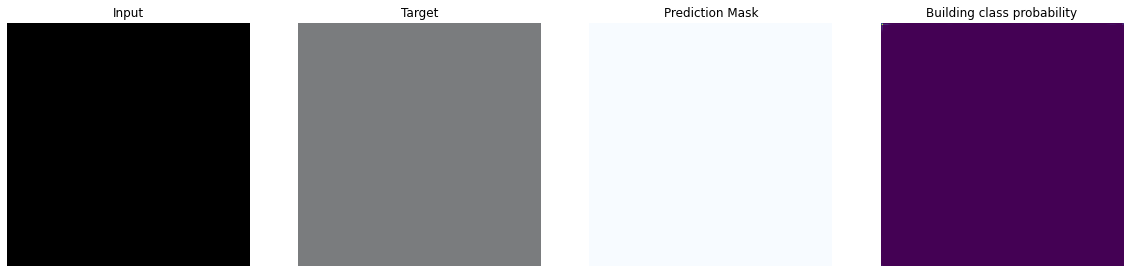

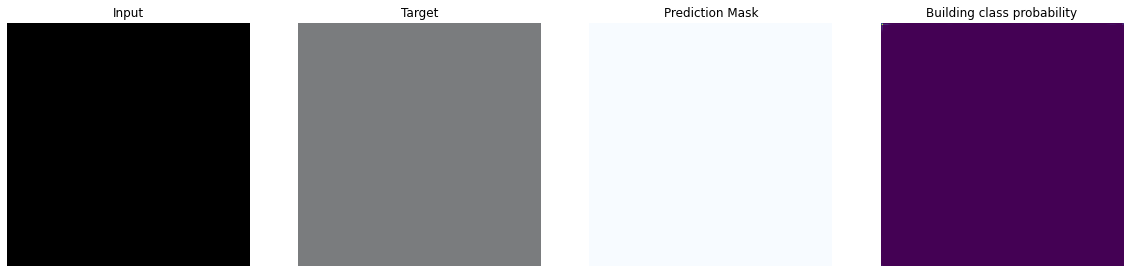

In [ ]:
#collapse
for idx in loss_sorted[-21:-18]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

In [ ]:
#collapse
def save_predictions(scene, path=path) -> None:
  "Predicts all 16 tiles of one scene and saves them to disk"
  output_folder = path/'predicted_tiles'
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)
  tiles = get_image_files(path/'img_tiles').sorted()
  for i in range(16):
    tile_preds = learn.predict(tiles[i])
    to_image(tile_preds[2][1].repeat(3,1,1)).save(output_folder/f'{i:02d}.png')


#collapse
def save_predictions(image) -> None:
  "Predicts all 16 tiles of one scene and saves them to disk"
  output_folder = path/'predicted_tiles'
  tile_preds = learn.predict(image)
  to_image(tile_preds[2][1].repeat(3,1,1)).save(output_folder/f'{image.name}')
  # if not os.path.exists(output_folder):
  #   os.makedirs(output_folder)
  # tiles = get_image_files(path/'img_tiles').sorted()
  # for i in range(16):
  #   tile_preds = learn.predict(tiles[i])
  #   to_image(tile_preds[2][1].repeat(3,1,1)).save(output_folder/f'{i:02d}.png')

In [ ]:
scene = VALID_SCENES[0] # 'L15-0571E-1075N_2287_3888_13'

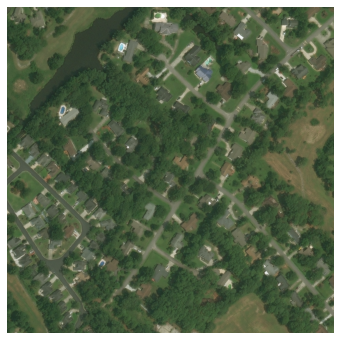

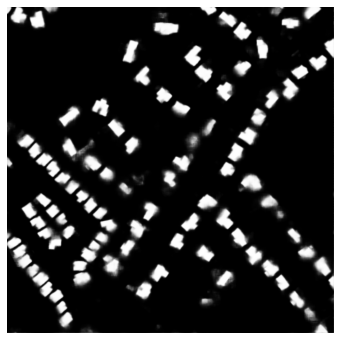

In [ ]:
# image.show()
# show_image(image)
output_folder = path/'predicted_tiles'
show_image(PILImage.create(image), figsize=(6,6));
show_image(PILImage.create(output_folder/f'{image.name}'), figsize=(6,6));

In [ ]:
save_predictions(image)

Helper function to show several tiles as a large image:

In [ ]:
#collapse
def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.

    Source: https://stackoverflow.com/a/16873755
    """
    try: # with color channel
      n, nrows, ncols, c = arr.shape
      return (arr.reshape(h//nrows, -1, nrows, ncols, c)
                .swapaxes(1,2)
                .reshape(h, w, c))
    except ValueError: # without color channel
      n, nrows, ncols = arr.shape
      return (arr.reshape(h//nrows, -1, nrows, ncols)
                .swapaxes(1,2)
                .reshape(h, w))

Load saved predictions:

In [ ]:
#collapse
def get_saved_preds(scene, path=path):
  "Load saved prediction mask tiles for a scene and return image + assembled mask"
  image_file = (path/scene/'images_masked').ls()[0]
  image = load_image(image_file)

  mask_tiles = get_image_files(path/scene/'predicted_tiles').sorted()
  mask_arrs = np.array(list(maps(partial(load_image, mode="L"), np.asarray, mask_tiles)))
  mask_array = unblockshaped(np.array(mask_arrs), 1020, 1020)

  return (image, mask_array)

Show image + stitched predictions:

In [ ]:
#collapse
def show_complete_preds(image, mask_array, scene):
  "Source: https://github.com/CosmiQ/CosmiQ_SN7_Baseline/blob/master/notebooks/sn7_baseline.ipynb"
  figsize = (25, 16)
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
  _ = ax0.imshow(image)
  ax0.set_xticks([])
  ax0.set_yticks([])
  ax0.set_title('Image')
  _ = ax1.imshow(mask_array, cmap='viridis')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title('Prediction Mask')
  plt.suptitle(scene)
  plt.tight_layout()
  plt.savefig(os.path.join(path, scene + '_im0+mask0+dice575.png'))
  plt.show()

In [ ]:
show_complete_preds(*get_saved_preds(scene), scene)

<img src="../images/articles/2021-spacenet7/fullscene1.jpg" />

In [ ]:
# hide
# for scene in VALID_SCENES:
#   save_predictions(scene)
#   show_complete_preds(*get_saved_preds(scene), scene)

## Discussion

I'm not sure how to rate the results because I don't have any comparison. A Dice score of `0.57` doesn't sound great. But considering how difficult the dataset is and that I didn't customize the architecture at all, I'm quite pleased with the result. There is a lot to improve however! The original SpaceNet7 challenge required recognizing individual buildings and tracking them trough time, that's something I'd like to work on in the future.

### What worked?
*  Using a **pretrained encoder**.
*  **Ignoring most images** of the dataset. I tried using `5` instead of `1` images per scene, which increased training time by `5` but did not improve the results significantly.
*  Standard **data augmentations**. Without them, the model started to overfit sooner.
*  **Undersampling**. While it did not have a large effect, it sped up training a little bit and it helped the accuracy.
*  **Weighted cross-entropy loss**. Without the weights, the model had a strong bias towards the dominating `background` class and failed to recognize many buildings.

### What didn't?
*  I hoped to get faster training with the **`Mish` activation function**, but training was unstable.
*  **Dice loss** instead of cross-entropy loss was unstable as well.
*  I tried adding **self-attention** to the U-Net, I hoped it would help classifying larger structures. I did not notice a significant difference.
*  A **deeper xResNet50 encoder** that I tried increased training time `6`-fold, but did not improve results.

### Other ideas to improve the results
* Better **data processing**: using overlapping tiles, scaling up the image tiles
* Dynamic **thresholding** for turning the predicted probabilities into a binary mask.
* Implement **recent advancements** in segmentation models, ie [UNet with ASPP](https://www.researchgate.net/figure/The-improved-U-net-with-atrous-spatial-pyramid-pooling-ASPP-integration-The-ASPP_fig3_332737684) or [Eff-UNet](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w22/Baheti_Eff-UNet_A_Novel_Architecture_for_Semantic_Segmentation_in_Unstructured_Environment_CVPRW_2020_paper.pdf)
* **More compute**: Deeper models. Use cross-validation with several folds to utilize all 60 scenes. Ensemble different models.

Thank you for reading this far! The challenge was fun and I learned a lot. There is also a lot of room for improvement and work to do :)